In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import os
import itertools

temp = os.getcwd()
print(f'Current working directory: {temp}')
if '/project2' in temp:
    temp = temp.replace('/project2', '')
    os.chdir(temp)
    print(f'Switched to: {temp}')

Current working directory: /Users/marco/dev/time-series


In [2]:
def import_stocks(name):
    df = pd.read_excel('data/'+str(name)+'.xlsx', header=3, index_col='Date')
    df = df.reindex(index=df.index[::-1])           # Go from old to new, instead of new to old
    df.index = pd.to_datetime(df.index)
    return df

def calc_log_returns(df):
    df['Log-Close'] = np.log(df['Close'])
    df['Log-Return'] = df['Log-Close'].diff()
    return 

names = ['EDP RENOVAVEISprice', 'GALP ENERGIA-NOMprice', 'MOTA ENGILprice', 'NOSSGPSprice', 'NOVABASESGPSprice']

edp = import_stocks(names[0])
galp = import_stocks(names[1])
mota = import_stocks(names[2])
noss = import_stocks(names[3])
nova = import_stocks(names[4])

for stock_df in [edp, galp, mota, noss, nova]:
    calc_log_returns(stock_df)                                      # Add new column with log return                     
    stock_df.drop(index=stock_df.index[0], axis=0, inplace=True)    # Drop first row, because no log return 

edp

,Open,High,Low,Close,Number of Shares,Number of Trades,Turnover,vwap,Log-Close,Log-Return
Date,,,,,,,,,,
2020-03-23,9.00,9.01,8.43,8.89,979383,2492,8547957,8.7279,2.184927,-0.048308
2020-03-24,9.01,9.56,8.87,9.56,985463,2133,9045053,9.1785,2.257588,0.072661
2020-03-25,9.80,10.14,9.27,9.75,539976,1103,5248850,9.7205,2.277267,0.019680
2020-03-26,9.56,10.20,9.36,10.20,495769,1401,4862624,9.8082,2.322388,0.045120
2020-03-27,10.02,10.28,9.88,10.08,422322,985,4271185,10.1136,2.310553,-0.011834
...,...,...,...,...,...,...,...,...,...,...
2022-03-07,20.54,22.06,20.40,21.76,1630709,4034,35106991,21.5287,3.080073,0.054782
2022-03-08,21.50,23.00,21.50,22.62,1851121,6269,41788673,22.5748,3.118834,0.038761
2022-03-09,23.22,23.76,22.20,23.18,1504596,4702,34471844,22.9110,3.143290,0.024455


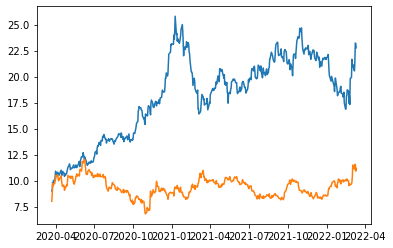

In [3]:

plt.plot(edp.Open)
plt.plot(galp.Open)
plt.plot()
plt.show()

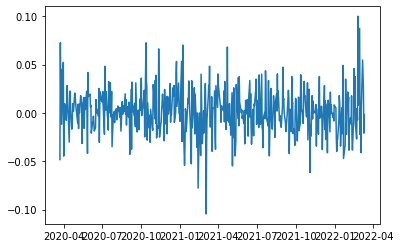

In [4]:
plt.plot(edp['Log-Return'])
plt.show()

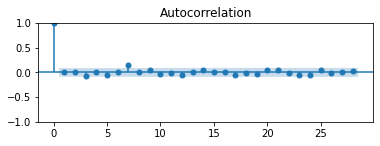

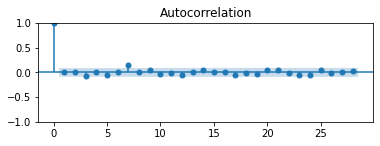

In [5]:
plot_acf(edp['Log-Return'], ax=plt.subplot(2, 1, 1))

In [16]:
model = arch_model(edp['Log-Return'], mean='Zero', vol='GARCH', p=1, q=1)
model_fit = model.fit()
print(model_fit.summary)
# was macht man jetzt damit

p_list = list(range(1, 10))
q_list = list(range(1, 10))
model_dict = {}

for p,q in itertools.product(p_list, q_list):
    model = arch_model(edp['Log-Return'], mean='Zero', vol='GARCH', p=p, q=q, rescale=False)
    model_fit = model.fit()
    model_dict[f'{p},{q}'] = (model_fit.bic, model_fit)
    print(f'{p},{q}: {model_fit.aic}')



/Users/marco/anaconda3/envs/ts/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005567. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -1190.4454210653603
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1190.4454199599147
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:             Log-Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                1190.45
Distribution:                  Normal   AIC:                          -2374.89
Method:            Maximum Likelihood   BIC:                          -2362.20
                                        No. Observations:                  508
Date:                Tue, Jun 14 2022   Df Residuals:                      508
Time:                        16:04:38   Df Mo

In [24]:
best_key = min(model_dict, key=lambda key: model_dict[key][0])
print(best_key)
print(model_dict[best_key][1])


1,1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log-Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                1190.45
Distribution:                  Normal   AIC:                          -2374.89
Method:            Maximum Likelihood   BIC:                          -2362.20
                                        No. Observations:                  508
Date:                Tue, Jun 14 2022   Df Residuals:                      508
Time:                        16:04:38   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.1194e-05  3.355e-11  3.337e+05      0.000

In [26]:
worst_key = max(model_dict, key=lambda key: model_dict[key][0])
print(worst_key)
print(model_dict[worst_key][1])

9,8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:             Log-Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                1190.65
Distribution:                  Normal   AIC:                          -2345.31
Method:            Maximum Likelihood   BIC:                          -2269.16
                                        No. Observations:                  508
Date:                Tue, Jun 14 2022   Df Residuals:                      508
Time:                        16:04:44   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.6850e-04  1.477e-04      1.141      0.